In [ ]:
import numpy as np

def imq_phi(r, alpha):
    """IMQ kernel φ(r) = 1/sqrt(1+(r/α)^2)."""
    return 1.0 / np.sqrt(1.0 + (r/alpha)**2)


# ---------------- Method 1: Naive subtraction ----------------
def imq_diff_naive(xi, xj, xk, alpha):
    """Naive difference φ(r_ik) - φ(r_ij)."""
    rij = np.linalg.norm(xi - xj)
    rik = np.linalg.norm(xi - xk)
    return imq_phi(rik, alpha) - imq_phi(rij, alpha)


# ---------------- Method 2: Stable algebraic factorization ----------------
def imq_diff_algebraic(xi, xj, xk, alpha):
    """
    Stable algebraic factorization:
    φ(rk) - φ(rj) = (a_j - a_k) / [sqrt(a_j)a_k*(sqrt(a_j)+sqrt(a_k))],
    where a_p = 1 + (r_ip/α)^2.
    """
    rij2 = np.dot(xi - xj, xi - xj)
    rik2 = np.dot(xi - xk, xi - xk)
    aj = 1.0 + rij2 / alpha**2
    ak = 1.0 + rik2 / alpha**2
    num = (rij2 - rik2) / alpha**2
    denom = np.sqrt(aj) * np.sqrt(ak) * (np.sqrt(aj) + np.sqrt(ak))
    return num / denom


# ---------------- Method 3: Integral midpoint approximation ----------------
def imq_diff_midpoint_integral(xi, xj, xk, alpha):
    """
    Approximate φ(rk) - φ(rj) by the midpoint rule applied to
    the integral form φ(rk)-φ(rj) = ∫_0^1 d/ds φ(r(s)) ds,
    where d/ds φ(r(s)) = -[r̃(s)·r_jk] / [α²(1+(r(s)/α)²)^{3/2}].
    """
    rij = xi - xj
    rjk = xj - xk
    s = 0.5  # midpoint
    rtil = rij + s * rjk
    r = np.linalg.norm(rtil)
    num = - np.dot(rtil, rjk)
    denom = alpha**2 * (1.0 + (r/alpha)**2)**1.5
    return num / denom


# ---------------- Method 4: Directional derivative (small-gap limit) ----------------
def imq_diff_derivative_limit(xi, xj, xk, alpha):
    """
    Small-gap limit (directional derivative):
    ≈ - [ (x_i - m)·v̂ ] / [ α²(1+(||x_i-m||/α)²)^{3/2} ],
    where m = (xj+xk)/2 and v̂ is the unit direction from xj→xk.
    """
    m = 0.5 * (xj + xk)
    v = xk - xj
    h = np.linalg.norm(v)
    if h == 0:
        return 0.0
    vhat = v / h
    r_m = xi - m
    r = np.linalg.norm(r_m)
    return - np.dot(r_m, vhat) / (alpha**2 * (1.0 + (r/alpha)**2)**1.5)

In [ ]:

# Example setup (same as in your slides)
xi = np.array([1.0])
xj = np.array([1.000000000001])
xk = np.array([0.05])
alpha = 0.2
h = np.linalg.norm(xk - xj)

# --- Compute each method ---
diff_naive = imq_diff_naive(xi, xj, xk, alpha)
diff_alg = imq_diff_algebraic(xi, xj, xk, alpha)
diff_mid = imq_diff_midpoint_integral(xi, xj, xk, alpha)
deriv_lim = imq_diff_derivative_limit(xi, xj, xk, alpha)

# --- Compute difference quotient ---
diff_quot = diff_naive / h

# --- Print step-by-step results ---
print("Inverse Multiquadric Kernel Difference Example")
print(f"x_i={xi[0]}, x_j={xj[0]}, x_k={xk[0]}, alpha={alpha}, h={h}")
print("-" * 70)
print(f"1) Naive difference                = {diff_naive:.16f}")
print(f"   Difference quotient (diff/h)    = {diff_quot:.16f}")
print("-" * 70)
print(f"2) Stable algebraic factorization  = {diff_alg:.16f}")
print(f"   Difference quotient (diff/h)    = {diff_alg/h:.16f}")
print("-" * 70)
print(f"3) Midpoint integral (approx diff) = {diff_mid:.16f}")
print(f"   Error vs naive diff             = {diff_naive - diff_mid:.2e}")
print("-" * 70)
print(f"4) Derivative limit (small gap)    = {deriv_lim:.16f}")
print(f"   |diff/h| vs |derivative| diff   = {abs(abs(diff_quot) - abs(deriv_lim)):.2e}")
print("-" * 70)
print("Note: The magnitudes of (diff/h) and derivative_limit match closely;")
print("      their signs differ depending on the ordering (x_j→x_k).")


Inverse Multiquadric Kernel Difference Example
x_i=1.0, x_j=1.000000000001, x_k=0.05, alpha=0.2, h=0.950000000001
----------------------------------------------------------------------
1) Naive difference                = -0.7939895189501580
   Difference quotient (diff/h)    = -0.8357784409992866
----------------------------------------------------------------------
2) Stable algebraic factorization  = -0.7939895189501582
   Difference quotient (diff/h)    = -0.8357784409992868
----------------------------------------------------------------------
3) Midpoint integral (approx diff) = -0.6592403624534673
   Error vs naive diff             = -1.35e-01
----------------------------------------------------------------------
4) Derivative limit (small gap)    = 0.6939372236344982
   |diff/h| vs |derivative| diff   = 1.42e-01
----------------------------------------------------------------------
Note: The magnitudes of (diff/h) and derivative_limit match closely;
      their signs differ dep

In [ ]:
# ----------------------------------------------------------------------
# BONUS: Accuracy comparison for very small h (to see cancellation)
# ----------------------------------------------------------------------
import mpmath as mp

def imq_phi_mp(r, alpha):
    return 1 / mp.sqrt(1 + (r/alpha)**2)

def imq_diff_ref_mp(xi, xj, xk, alpha, prec=80):
    """High-precision reference difference using mpmath."""
    with mp.workdps(prec):
        xi_m, xj_m, xk_m, a_m = mp.mpf(xi), mp.mpf(xj), mp.mpf(xk), mp.mpf(alpha)
        rij = mp.fabs(xi_m - xj_m)
        rik = mp.fabs(xi_m - xk_m)
        return imq_phi_mp(rik, a_m) - imq_phi_mp(rij, a_m)

print("\nNumerical Stability Test — shrinking h:")
print(f"{'h':>10} {'reference':>20} {'naive':>20} {'algebraic':>20} {'rel_err(naive)':>18} {'rel_err(alg)':>18}")
print("-" * 110)

xi, xj, alpha = 1.0, 0.0, 0.2
hs = [10.0**(-k) for k in range(1, 15)]  # from 1e-1 down to 1e-14

for h in hs:
    xk = h
    ref = float(imq_diff_ref_mp(xi, xj, xk, alpha, prec=80))
    diff_naive = imq_diff_naive(xi, xj, xk, alpha)
    diff_alg   = imq_diff_algebraic(xi, xj, xk, alpha)
    rel_naive  = abs((diff_naive - ref) / ref)
    rel_alg    = abs((diff_alg - ref) / ref)
    print(f"{h:10.1e} {ref:20.12e} {diff_naive:20.12e} {diff_alg:20.12e} {rel_naive:18.2e} {rel_alg:18.2e}")



Numerical Stability Test — shrinking h:
         h            reference                naive            algebraic     rel_err(naive)       rel_err(alg)
--------------------------------------------------------------------------------------------------------------
   1.0e-01   2.081432268047e-02   2.081432268047e-02   2.081432268047e-02           1.17e-15           6.67e-16
   1.0e-02   1.903666842014e-03   1.903666842014e-03   1.903666842014e-03           1.82e-15           1.37e-15
   1.0e-03   1.887510648805e-04   1.887510648805e-04   1.887510648805e-04           8.98e-14           1.35e-14
   1.0e-04   1.885909779010e-05   1.885909779012e-05   1.885909779009e-05           1.12e-12           3.61e-13
   1.0e-05   1.885749838199e-06   1.885749838171e-06   1.885749838189e-06           1.47e-11           4.96e-12
   1.0e-06   1.885733845578e-07   1.885733845741e-07   1.885733845653e-07           8.66e-11           3.98e-11
   1.0e-07   1.885732246330e-08   1.885732245355e-08   1.8857322


Inverse Multiquadric Kernel Difference Example
x_i=1.0, x_j=0.0, x_k=0.01, alpha=0.2, h=0.01
----------------------------------------------------------------------
1) Naive difference                = 1.9036668420139846e-03
   Difference quotient (diff/h)    = 1.9036668420139846e-01
2) Stable algebraic factorization  = 1.9036668420139907e-03
   Difference quotient (diff/h)    = 1.9036668420139907e-01
3) Midpoint integral (approx diff) = 1.9036251234676197e-03
   Error vs naive diff             = 4.17e-08
4) Derivative limit (small gap)    = -1.9036251234676196e-01
   |diff/h| vs |derivative| diff   = 4.17e-06
----------------------------------------------------------------------

Numerical Stability Test — shrinking h:
         h            reference                naive            algebraic     rel_err(naive)       rel_err(alg)
--------------------------------------------------------------------------------------------------------------
   1.0e-01   2.081432268047e-02   2.08143226804

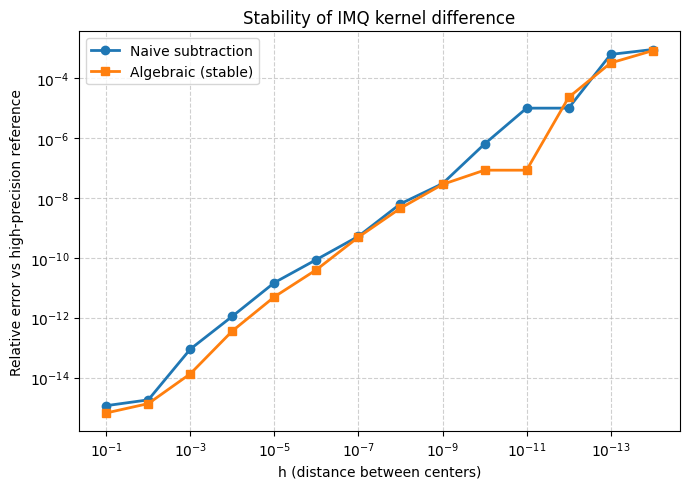

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp

# ==========================================================
# 1️⃣  Example setup and basic comparison (as before)
# ==========================================================
xi = np.array([1.0])
xj = np.array([0.0])
xk = np.array([0.01])
alpha = 0.2
h = np.linalg.norm(xk - xj)

diff_naive = imq_diff_naive(xi, xj, xk, alpha)
diff_alg   = imq_diff_algebraic(xi, xj, xk, alpha)
diff_mid   = imq_diff_midpoint_integral(xi, xj, xk, alpha)
deriv_lim  = imq_diff_derivative_limit(xi, xj, xk, alpha)
diff_quot  = diff_naive / h

print("\nInverse Multiquadric Kernel Difference Example")
print(f"x_i={xi[0]}, x_j={xj[0]}, x_k={xk[0]}, alpha={alpha}, h={h}")
print("-" * 70)
print(f"1) Naive difference                = {diff_naive:.16e}")
print(f"   Difference quotient (diff/h)    = {diff_quot:.16e}")
print(f"2) Stable algebraic factorization  = {diff_alg:.16e}")
print(f"   Difference quotient (diff/h)    = {diff_alg/h:.16e}")
print(f"3) Midpoint integral (approx diff) = {diff_mid:.16e}")
print(f"   Error vs naive diff             = {diff_naive - diff_mid:.2e}")
print(f"4) Derivative limit (small gap)    = {deriv_lim:.16e}")
print(f"   |diff/h| vs |derivative| diff   = {abs(abs(diff_quot)-abs(deriv_lim)):.2e}")
print("-" * 70)

# ==========================================================
# 2️⃣  Numerical stability test for small h
# ==========================================================
def imq_phi_mp(r, alpha):
    return 1 / mp.sqrt(1 + (r/alpha)**2)

def imq_diff_ref_mp(xi, xj, xk, alpha, prec=80):
    """High-precision reference difference using mpmath."""
    with mp.workdps(prec):
        xi_m, xj_m, xk_m, a_m = mp.mpf(xi), mp.mpf(xj), mp.mpf(xk), mp.mpf(alpha)
        rij = mp.fabs(xi_m - xj_m)
        rik = mp.fabs(xi_m - xk_m)
        return imq_phi_mp(rik, a_m) - imq_phi_mp(rij, a_m)

print("\nNumerical Stability Test — shrinking h:")
print(f"{'h':>10} {'reference':>20} {'naive':>20} {'algebraic':>20} {'rel_err(naive)':>18} {'rel_err(alg)':>18}")
print("-" * 110)

xi, xj, alpha = 1.0, 0.0, 0.2
hs = [10.0**(-k) for k in range(1, 15)]  # 1e-1 to 1e-14

rel_naive_list, rel_alg_list = [], []

for h in hs:
    xk = h
    ref = float(imq_diff_ref_mp(xi, xj, xk, alpha, prec=80))
    diff_naive = imq_diff_naive(xi, xj, xk, alpha)
    diff_alg   = imq_diff_algebraic(xi, xj, xk, alpha)
    rel_naive  = abs((diff_naive - ref) / ref)
    rel_alg    = abs((diff_alg - ref) / ref)
    rel_naive_list.append(rel_naive)
    rel_alg_list.append(rel_alg)
    print(f"{h:10.1e} {ref:20.12e} {diff_naive:20.12e} {diff_alg:20.12e} {rel_naive:18.2e} {rel_alg:18.2e}")


plt.figure(figsize=(7,5))
plt.loglog(hs, rel_naive_list, 'o-', label="Naive subtraction", linewidth=2)
plt.loglog(hs, rel_alg_list, 's-', label="Algebraic (stable)", linewidth=2)
plt.gca().invert_xaxis()  # small h to the right
plt.xlabel("h (distance between centers)")
plt.ylabel("Relative error vs high-precision reference")
plt.title("Stability of IMQ kernel difference")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


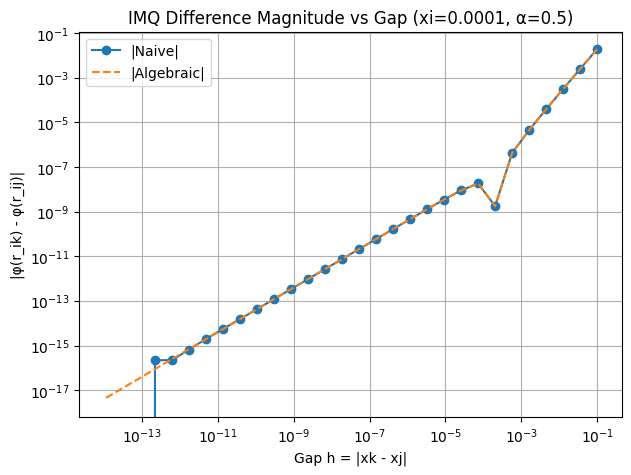

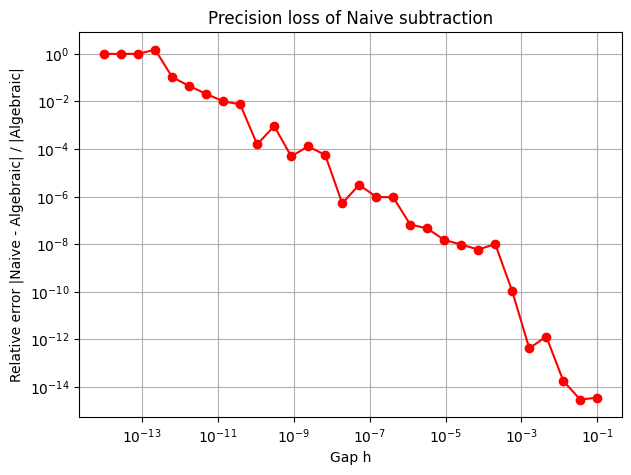

In [ ]:
def compare_precision(alpha=0.5, xi_val=0.0001):
    xj = np.array([0.0])
    hs = np.logspace(-1, -14, 30)   # much smaller gaps
    diffs_naive, diffs_alg, rel_error = [], [], []

    for h in hs:
        xk = np.array([h])
        xi = np.array([xi_val])
        d_naive = imq_diff_naive(xi, xj, xk, alpha)
        d_alg   = imq_diff_algebraic(xi, xj, xk, alpha)
        diffs_naive.append(d_naive)
        diffs_alg.append(d_alg)
        rel_error.append(abs(d_naive - d_alg) / (abs(d_alg) + 1e-30))

    plt.figure(figsize=(7,5))
    plt.loglog(hs, np.abs(diffs_naive), 'o-', label='|Naive|')
    plt.loglog(hs, np.abs(diffs_alg), '--', label='|Algebraic|')
    plt.xlabel('Gap h = |xk - xj|')
    plt.ylabel('|φ(r_ik) - φ(r_ij)|')
    plt.title(f'IMQ Difference Magnitude vs Gap (xi={xi_val}, α={alpha})')
    plt.legend()
    plt.grid(True, which='both')
    plt.show()

    plt.figure(figsize=(7,5))
    plt.loglog(hs, rel_error, 'r-o')
    plt.xlabel('Gap h')
    plt.ylabel('Relative error |Naive - Algebraic| / |Algebraic|')
    plt.title('Precision loss of Naive subtraction')
    plt.grid(True, which='both')
    plt.show()

compare_precision(alpha=0.5, xi_val=0.0001)


Max relative error (naive):  3.975e-01
Max relative error (stable): 5.882e-16
Median relative error (naive):  2.100e-09
Median relative error (stable): 1.456e-16


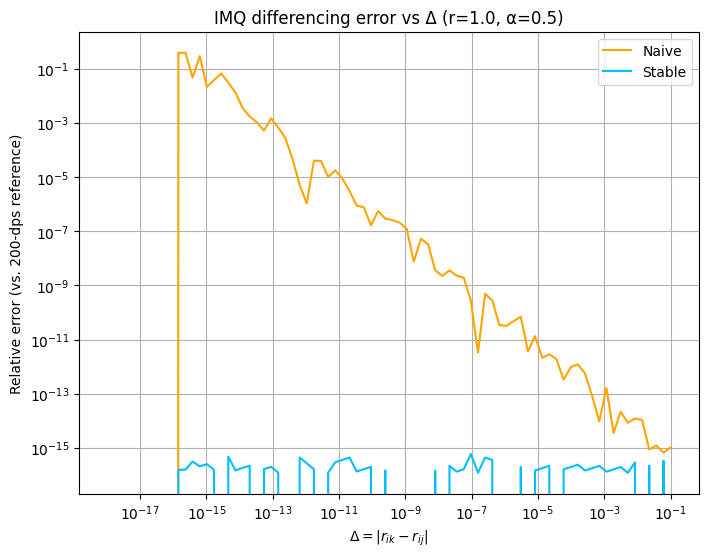

In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt


# IMQ kernel φ(r; α)

def imq_phi(r, alpha):
    """IMQ kernel φ(r;α) = 1/sqrt(1 + (r/α)^2)."""
    return 1.0 / np.sqrt(1.0 + (r / alpha)**2)


def imq_phi_mp(r, alpha):
    """High-precision IMQ kernel using mpmath."""
    r = mp.mpf(r)
    alpha = mp.mpf(alpha)
    return 1 / mp.sqrt(1 + (r / alpha)**2)


# Difference formulas

def imq_diff_naive(rij, rik, alpha):
    """
    Naive difference: φ(rik) - φ(rij).
    This form loses precision for small |rik - rij|.
    """
    return imq_phi(rik, alpha) - imq_phi(rij, alpha)


def imq_diff_stable(rij, rik, alpha):
    """
    Stable difference formula for IMQ kernel to avoid catastrophic cancellation.
    Derived via rationalized conjugate form.
    """
    rjk = rij - rik
    term_ij = np.sqrt(1.0 + (rij / alpha)**2)
    term_ik = np.sqrt(1.0 + (rik / alpha)**2)

    numerator = (rjk / alpha**2) * (rij + rik)
    denominator = term_ij * term_ik * (term_ij + term_ik)
    return numerator / denominator


def imq_diff_mp(rij, rik, alpha, dps=120):
    """High-precision reference difference using mpmath."""
    with mp.workdps(dps):
        return imq_phi_mp(rik, alpha) - imq_phi_mp(rij, alpha)


# Test Dataset

def rel_error(approx, truth):
    """Relative error utility."""
    if truth == 0:
        return abs(approx - truth)
    return abs((approx - truth) / truth)


def run_experiment(r_base=1.0, alpha=0.5, deltas=None, dps=200):
    """
    Sweep over small deltas near r_base to test cancellation behavior.
    Returns arrays of delta, relative error (naive, stable).
    """
    if deltas is None:
        deltas = np.logspace(-18, -1, 80)  # test from 1e-18 to 1e-1

    rel_err_naive = []
    rel_err_stable = []

    for d in deltas:
        rij = r_base
        rik = r_base + d
        truth = float(imq_diff_mp(rij, rik, alpha, dps=dps))
        naive = imq_diff_naive(rij, rik, alpha)
        stable = imq_diff_stable(rij, rik, alpha)

        rel_err_naive.append(rel_error(naive, truth))
        rel_err_stable.append(rel_error(stable, truth))

    return deltas, np.array(rel_err_naive), np.array(rel_err_stable)


# Plotting results

def plot_errors(deltas, err_naive, err_stable, r_base, alpha):
    """Plot relative errors vs Δ for both methods."""
    plt.figure(figsize=(8, 6))
    plt.loglog(deltas, err_naive, 'orange', label='Naive')
    plt.loglog(deltas, err_stable, 'deepskyblue', label='Stable')
    plt.xlabel(r'$\Delta = |r_{ik} - r_{ij}|$')
    plt.ylabel('Relative error (vs. 200-dps reference)')
    plt.title(f'IMQ differencing error vs Δ (r={r_base}, α={alpha})')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()


# Main driver

def main():
    alpha = 0.5
    r_base = 1.0
    deltas, err_naive, err_stable = run_experiment(r_base, alpha)

    print(f"Max relative error (naive):  {np.max(err_naive):.3e}")
    print(f"Max relative error (stable): {np.max(err_stable):.3e}")
    print(f"Median relative error (naive):  {np.median(err_naive):.3e}")
    print(f"Median relative error (stable): {np.median(err_stable):.3e}")

    plot_errors(deltas, err_naive, err_stable, r_base, alpha)


# Execute

if __name__ == "__main__":
    main()


Max relative error (naive):       3.975e-01
Max relative error (stable):      5.882e-16
Max relative error (mean-value):  9.932e-04
Median relative error (naive):       2.100e-09
Median relative error (stable):      1.456e-16
Median relative error (mean-value):  1.580e-16


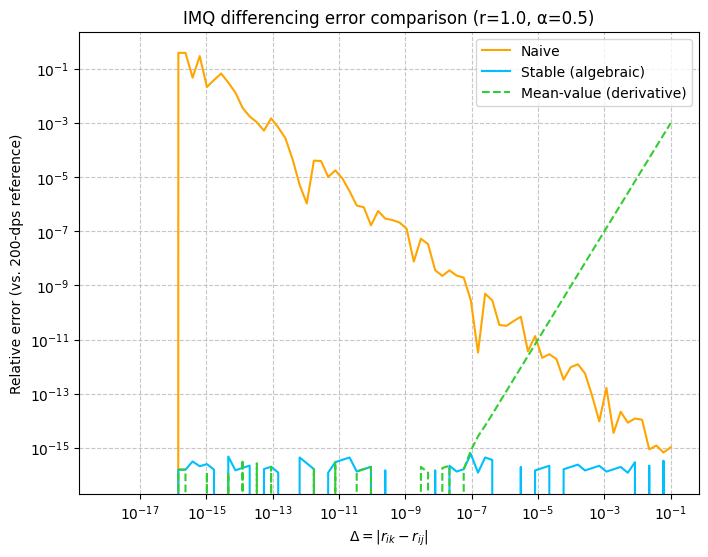

In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt


# IMQ kernel and derivative

def imq_phi(r, alpha):
    """IMQ kernel φ(r; α) = 1 / sqrt(1 + (r/α)^2)."""
    return 1.0 / np.sqrt(1.0 + (r / alpha)**2)


def imq_phi_mp(r, alpha):
    """High-precision IMQ kernel using mpmath."""
    r = mp.mpf(r)
    alpha = mp.mpf(alpha)
    return 1 / mp.sqrt(1 + (r / alpha)**2)


def imq_phi_prime(r, alpha):
    """Derivative φ'(r; α) = - (r / α^2) / (1 + (r/α)^2)^(3/2)."""
    return - (r / alpha**2) / (1.0 + (r / alpha)**2)**1.5


# IMQ differencing formulas

def imq_diff_naive(rij, rik, alpha):
    """Naive difference φ(rik) - φ(rij) (suffers from cancellation)."""
    return imq_phi(rik, alpha) - imq_phi(rij, alpha)


def imq_diff_stable(rij, rik, alpha):
    """Algebraically stable differencing formula."""
    rjk = rij - rik
    term_ij = np.sqrt(1.0 + (rij / alpha)**2)
    term_ik = np.sqrt(1.0 + (rik / alpha)**2)
    numerator = (rjk / alpha**2) * (rij + rik)
    denominator = term_ij * term_ik * (term_ij + term_ik)
    return numerator / denominator


def imq_diff_meanvalue(rij, rik, alpha):
    """
    Mean-value theorem (derivative-based) approximation:
    φ(rik) - φ(rij) ≈ φ'(r_mid) * (rik - rij),
    where r_mid = (rij + rik)/2.
    """
    r_mid = 0.5 * (rij + rik)
    r_diff = rik - rij
    return imq_phi_prime(r_mid, alpha) * r_diff


def imq_diff_mp(rij, rik, alpha, dps=120):
    """High-precision reference difference using mpmath."""
    with mp.workdps(dps):
        return imq_phi_mp(rik, alpha) - imq_phi_mp(rij, alpha)

def rel_error(approx, truth):
    """Compute relative error (robust to zero truth)."""
    if truth == 0:
        return abs(approx - truth)
    return abs((approx - truth) / truth)


def run_experiment(r_base=1.0, alpha=0.5, deltas=None, dps=200):
    """
    Sweep over small deltas near r_base to test cancellation behavior.
    Returns arrays of delta and relative errors for all methods.
    """
    if deltas is None:
        deltas = np.logspace(-18, -1, 80)  # from 1e-18 to 1e-1

    err_naive, err_stable, err_meanvalue = [], [], []

    for d in deltas:
        rij = r_base
        rik = r_base + d
        truth = float(imq_diff_mp(rij, rik, alpha, dps=dps))

        naive = imq_diff_naive(rij, rik, alpha)
        stable = imq_diff_stable(rij, rik, alpha)
        meanval = imq_diff_meanvalue(rij, rik, alpha)

        err_naive.append(rel_error(naive, truth))
        err_stable.append(rel_error(stable, truth))
        err_meanvalue.append(rel_error(meanval, truth))

    return deltas, np.array(err_naive), np.array(err_stable), np.array(err_meanvalue)


def plot_errors(deltas, err_naive, err_stable, err_meanvalue, r_base, alpha):
    """Plot relative errors for all three methods."""
    plt.figure(figsize=(8, 6))
    plt.loglog(deltas, err_naive, 'orange', label='Naive')
    plt.loglog(deltas, err_stable, 'deepskyblue', label='Stable (algebraic)')
    plt.loglog(deltas, err_meanvalue, 'limegreen', linestyle='--', label='Mean-value (derivative)')
    plt.xlabel(r'$\Delta = |r_{ik} - r_{ij}|$')
    plt.ylabel('Relative error (vs. 200-dps reference)')
    plt.title(f'IMQ differencing error comparison (r={r_base}, α={alpha})')
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.7)
    plt.show()


def main():
    alpha = 0.5
    r_base = 1.0

    deltas, err_naive, err_stable, err_meanvalue = run_experiment(r_base, alpha)

    print(f"Max relative error (naive):       {np.max(err_naive):.3e}")
    print(f"Max relative error (stable):      {np.max(err_stable):.3e}")
    print(f"Max relative error (mean-value):  {np.max(err_meanvalue):.3e}")
    print(f"Median relative error (naive):       {np.median(err_naive):.3e}")
    print(f"Median relative error (stable):      {np.median(err_stable):.3e}")
    print(f"Median relative error (mean-value):  {np.median(err_meanvalue):.3e}")

    plot_errors(deltas, err_naive, err_stable, err_meanvalue, r_base, alpha)


if __name__ == "__main__":
    main()


Max relative error (naive):       3.975e-01
Max relative error (stable):      5.882e-16
Max relative error (mean-value 1): 9.932e-04
Max relative error (mean-value 3): 8.728e-08

Median relative error (naive):       2.100e-09
Median relative error (stable):      1.456e-16
Median relative error (mean-value 1): 1.580e-16
Median relative error (mean-value 3): 0.000e+00


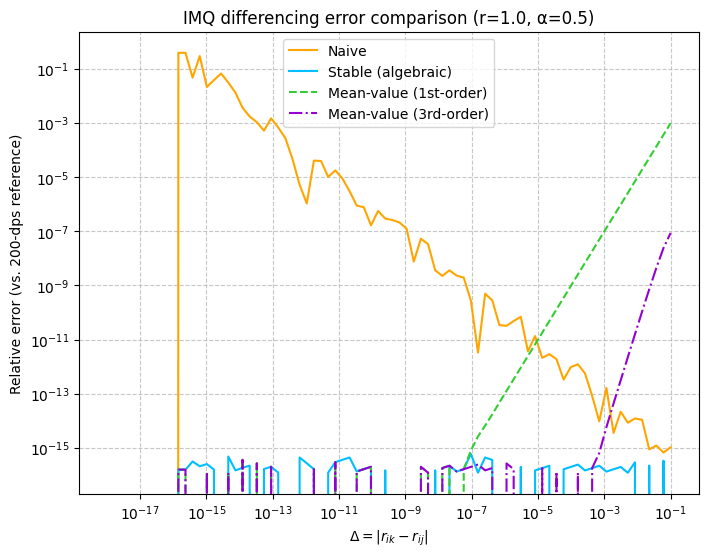

In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# IMQ kernel and derivatives
# ---------------------------------------------------------

def imq_phi(r, alpha):
    """IMQ kernel φ(r; α) = 1 / sqrt(1 + (r/α)^2)."""
    return 1.0 / np.sqrt(1.0 + (r / alpha)**2)

def imq_phi_mp(r, alpha):
    """High-precision IMQ kernel using mpmath."""
    r = mp.mpf(r)
    alpha = mp.mpf(alpha)
    return 1 / mp.sqrt(1 + (r / alpha)**2)

def imq_phi_prime(r, alpha):
    """φ'(r; α) = -(r/α²) / (1 + (r/α)²)^(3/2)."""
    return - (r / alpha**2) / (1.0 + (r / alpha)**2)**1.5

def imq_phi_third(r, alpha):
    """
    Third derivative φ'''(r; α).
    Derived analytically for IMQ kernel.
    """
    num = 3 * alpha * r * (3 * alpha**2 - 2 * r**2)
    den = (alpha**2 + r**2)**3.5
    return num / den


# ---------------------------------------------------------
# IMQ differencing formulas
# ---------------------------------------------------------

def imq_diff_naive(rij, rik, alpha):
    """Naive subtraction φ(rik) - φ(rij)."""
    return imq_phi(rik, alpha) - imq_phi(rij, alpha)

def imq_diff_stable(rij, rik, alpha):
    """Algebraically stable differencing formula."""
    rjk = rij - rik
    term_ij = np.sqrt(1.0 + (rij / alpha)**2)
    term_ik = np.sqrt(1.0 + (rik / alpha)**2)
    numerator = (rjk / alpha**2) * (rij + rik)
    denominator = term_ij * term_ik * (term_ij + term_ik)
    return numerator / denominator

def imq_diff_meanvalue(rij, rik, alpha):
    """1st-order Mean Value (midpoint rule)."""
    r_mid = 0.5 * (rij + rik)
    r_diff = rik - rij
    return imq_phi_prime(r_mid, alpha) * r_diff

def imq_diff_meanvalue_taylor(rij, rik, alpha):
    """3rd-order Mean Value (Taylor corrected)."""
    r_mid = 0.5 * (rij + rik)
    r_diff = rik - rij
    return (imq_phi_prime(r_mid, alpha) * r_diff
            + imq_phi_third(r_mid, alpha) * (r_diff**3) / 24.0)

def imq_diff_mp(rij, rik, alpha, dps=200):
    """High-precision reference using mpmath."""
    with mp.workdps(dps):
        return imq_phi_mp(rik, alpha) - imq_phi_mp(rij, alpha)


# ---------------------------------------------------------
# Utilities
# ---------------------------------------------------------

def rel_error(approx, truth):
    """Compute relative error (robust to zero truth)."""
    if truth == 0:
        return abs(approx - truth)
    return abs((approx - truth) / truth)

def run_experiment(r_base=1.0, alpha=0.5, deltas=None, dps=200):
    """Sweep over small Δ values and compute relative errors."""
    if deltas is None:
        deltas = np.logspace(-18, -1, 80)

    err_naive, err_stable, err_m1, err_m3 = [], [], [], []

    for d in deltas:
        rij, rik = r_base, r_base + d
        truth = float(imq_diff_mp(rij, rik, alpha, dps))

        naive = imq_diff_naive(rij, rik, alpha)
        stable = imq_diff_stable(rij, rik, alpha)
        mean1 = imq_diff_meanvalue(rij, rik, alpha)
        mean3 = imq_diff_meanvalue_taylor(rij, rik, alpha)

        err_naive.append(rel_error(naive, truth))
        err_stable.append(rel_error(stable, truth))
        err_m1.append(rel_error(mean1, truth))
        err_m3.append(rel_error(mean3, truth))

    return deltas, np.array(err_naive), np.array(err_stable), np.array(err_m1), np.array(err_m3)


# ---------------------------------------------------------
# Plotting
# ---------------------------------------------------------

def plot_errors(deltas, e_naive, e_stable, e_m1, e_m3, r_base, alpha):
    plt.figure(figsize=(8, 6))
    plt.loglog(deltas, e_naive, 'orange', label='Naive')
    plt.loglog(deltas, e_stable, 'deepskyblue', label='Stable (algebraic)')
    plt.loglog(deltas, e_m1, 'limegreen', linestyle='--', label='Mean-value (1st-order)')
    plt.loglog(deltas, e_m3, 'darkviolet', linestyle='-.', label='Mean-value (3rd-order)')
    plt.xlabel(r'$\Delta = |r_{ik} - r_{ij}|$')
    plt.ylabel('Relative error (vs. 200-dps reference)')
    plt.title(f'IMQ differencing error comparison (r={r_base}, α={alpha})')
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.7)
    plt.show()


# ---------------------------------------------------------
# Main
# ---------------------------------------------------------

def main():
    alpha, r_base = 0.5, 1.0
    deltas, e_naive, e_stable, e_m1, e_m3 = run_experiment(r_base, alpha)

    print(f"Max relative error (naive):       {np.max(e_naive):.3e}")
    print(f"Max relative error (stable):      {np.max(e_stable):.3e}")
    print(f"Max relative error (mean-value 1): {np.max(e_m1):.3e}")
    print(f"Max relative error (mean-value 3): {np.max(e_m3):.3e}")
    print()
    print(f"Median relative error (naive):       {np.median(e_naive):.3e}")
    print(f"Median relative error (stable):      {np.median(e_stable):.3e}")
    print(f"Median relative error (mean-value 1): {np.median(e_m1):.3e}")
    print(f"Median relative error (mean-value 3): {np.median(e_m3):.3e}")

    plot_errors(deltas, e_naive, e_stable, e_m1, e_m3, r_base, alpha)

if __name__ == "__main__":
    main()


Max relative error (naive):   3.975e-01
Max relative error (stable):  5.882e-16
Median relative error (naive):  2.100e-09
Median relative error (stable): 1.456e-16


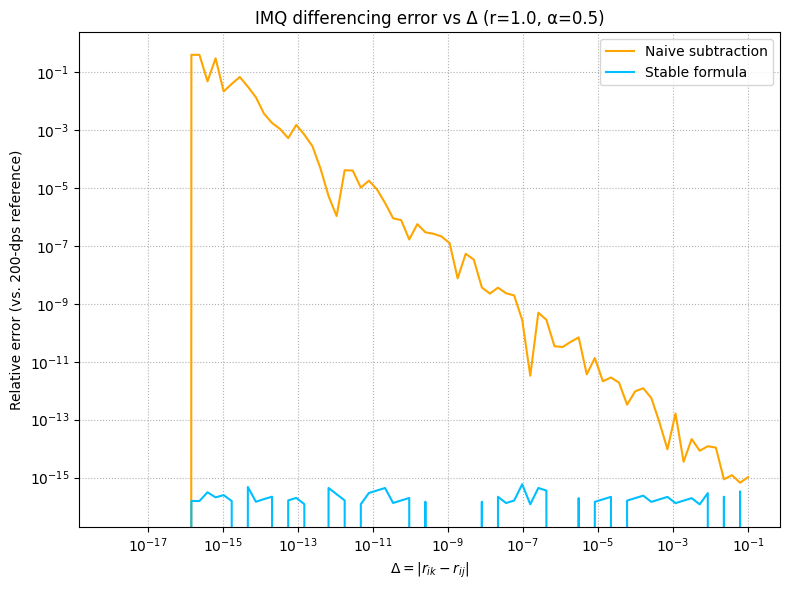

In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt


# INVERSE MULTIQUADRIC KERNEL

def imq_phi(r, alpha):
    """
    Standard IMQ kernel (double precision).

    φ(r; α) = 1 / sqrt(1 + (r/α)^2)

    Parameters
    ----------
    r : float or array
        Pairwise Euclidean distance |x_i - x_j|.
    alpha : float
        Kernel shape parameter controlling smoothness.

    Returns
    -------
    float
        IMQ kernel value.
    """
    return 1.0 / np.sqrt(1.0 + (r / alpha)**2)


def imq_phi_mp(r, alpha):
    """
    High-precision version of the IMQ kernel using mpmath.
    This helps generate a reliable reference value.
    """
    r = mp.mpf(r)
    alpha = mp.mpf(alpha)
    return 1 / mp.sqrt(1 + (r / alpha)**2)


# DIFFERENCE COMPUTATIONS

def imq_diff_naive(rij, rik, alpha):
    """
    Naive finite difference between two IMQ kernel evaluations:
        Δφ = φ(rik) - φ(rij)

    This direct subtraction is susceptible to catastrophic
    cancellation when |rik - rij| is very small, because both
    φ(rik) and φ(rij) are close in magnitude.
    """
    return imq_phi(rik, alpha) - imq_phi(rij, alpha)


def imq_diff_stable(rij, rik, alpha):
    """
    Numerically stable difference formula for IMQ kernel.

    Derivation idea:
    ----------------
    Multiply numerator and denominator by the conjugate
    to rationalize and cancel near-identical terms.

    Result:
        φ(rik) - φ(rij)
        ≈ [(r_ij - r_ik)(r_ij + r_ik)] /
           [α^2 * sqrt(1 + (r_ij/α)^2) * sqrt(1 + (r_ik/α)^2) *
            (sqrt(1 + (r_ij/α)^2) + sqrt(1 + (r_ik/α)^2))]

    This form avoids subtracting nearly equal numbers,
    making it more stable for small Δr = |r_ik - r_ij|.
    """
    rjk = rij - rik
    term_ij = np.sqrt(1.0 + (rij / alpha)**2)
    term_ik = np.sqrt(1.0 + (rik / alpha)**2)

    numerator = (rjk / alpha**2) * (rij + rik)
    denominator = term_ij * term_ik * (term_ij + term_ik)

    return numerator / denominator


def imq_diff_mp(rij, rik, alpha, dps=120):
    """
    High-precision ground truth for Δφ = φ(rik) - φ(rij)
    using arbitrary precision arithmetic (mpmath).

    Parameters
    ----------
    rij, rik : float
        Two distance values.
    alpha : float
        Kernel scale parameter.
    dps : int
        Decimal precision to use for mpmath context.
    """
    with mp.workdps(dps):
        return imq_phi_mp(rik, alpha) - imq_phi_mp(rij, alpha)


# ERROR METRICS

def rel_error(approx, truth):
    """
    Compute relative error |approx - truth| / |truth|.
    Handles the zero-denominator case safely.
    """
    if truth == 0:
        return abs(approx - truth)
    return abs((approx - truth) / truth)


# EXPERIMENT

def run_experiment(r_base=1.0, alpha=0.5, deltas=None, dps=200):
    """
    Sweep over a range of small distance differences Δ
    to evaluate when numerical precision breaks down.

    Parameters
    ----------
    r_base : float
        Base distance (e.g., r_ij).
    alpha : float
        Kernel shape parameter.
    deltas : array-like
        Small increments Δ = r_ik - r_ij to test.
        Defaults to logarithmic scale from 1e-18 to 1e-1.
    dps : int
        Decimal precision for high-accuracy reference.

    Returns
    -------
    deltas : np.ndarray
        Tested Δ values.
    rel_err_naive : np.ndarray
        Relative error for naive subtraction.
    rel_err_stable : np.ndarray
        Relative error for stable formula.
    """
    if deltas is None:
        deltas = np.logspace(-18, -1, 80)

    rel_err_naive = []
    rel_err_stable = []

    for d in deltas:
        rij = r_base
        rik = r_base + d

        # Reference high-precision result (ground truth)
        truth = float(imq_diff_mp(rij, rik, alpha, dps=dps))

        # Approximate double-precision results
        naive = imq_diff_naive(rij, rik, alpha)
        stable = imq_diff_stable(rij, rik, alpha)

        rel_err_naive.append(rel_error(naive, truth))
        rel_err_stable.append(rel_error(stable, truth))

    return deltas, np.array(rel_err_naive), np.array(rel_err_stable)


# PLOTTING

def plot_errors(deltas, err_naive, err_stable, r_base, alpha):
    """
    Log-log plot comparing relative errors of
    naive vs. stable differencing for IMQ kernel.
    """
    plt.figure(figsize=(8, 6))
    plt.loglog(deltas, err_naive, 'orange', label='Naive subtraction')
    plt.loglog(deltas, err_stable, 'deepskyblue', label='Stable formula')

    plt.xlabel(r'$\Delta = |r_{ik} - r_{ij}|$')
    plt.ylabel('Relative error (vs. 200-dps reference)')
    plt.title(f'IMQ differencing error vs Δ (r={r_base}, α={alpha})')
    plt.grid(True, which='both', ls=':')
    plt.legend()
    plt.tight_layout()
    plt.show()


# DRIVER

def main():
    """
    Run precision-comparison experiment between
    naive and stable IMQ differencing formulas.
    """
    alpha = 0.5
    r_base = 1.0

    # Run numerical test sweep
    deltas, err_naive, err_stable = run_experiment(r_base, alpha)

    # Summary statistics
    print(f"Max relative error (naive):   {np.max(err_naive):.3e}")
    print(f"Max relative error (stable):  {np.max(err_stable):.3e}")
    print(f"Median relative error (naive):  {np.median(err_naive):.3e}")
    print(f"Median relative error (stable): {np.median(err_stable):.3e}")

    # Visualization
    plot_errors(deltas, err_naive, err_stable, r_base, alpha)


# ENTRY

if __name__ == "__main__":
    main()


Max relative error (naive):       3.975e-01
Max relative error (stable):      5.882e-16
Max relative error (mean-value 1): 9.932e-04
Max relative error (mean-value 3): 8.728e-08

Median relative error (naive):       2.100e-09
Median relative error (stable):      1.456e-16
Median relative error (mean-value 1): 1.580e-16
Median relative error (mean-value 3): 0.000e+00


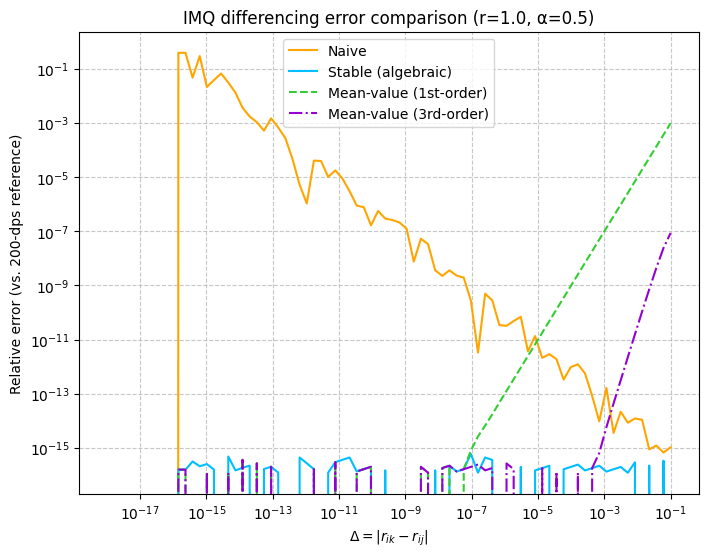

In [ ]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# IMQ kernel and derivatives
# ---------------------------------------------------------

def imq_phi(r, alpha):
    """IMQ kernel φ(r; α) = 1 / sqrt(1 + (r/α)^2)."""
    return 1.0 / np.sqrt(1.0 + (r / alpha)**2)

def imq_phi_mp(r, alpha):
    """High-precision IMQ kernel using mpmath."""
    r = mp.mpf(r)
    alpha = mp.mpf(alpha)
    return 1 / mp.sqrt(1 + (r / alpha)**2)

def imq_phi_prime(r, alpha):
    """φ'(r; α) = -(r/α²) / (1 + (r/α)²)^(3/2)."""
    return - (r / alpha**2) / (1.0 + (r / alpha)**2)**1.5

def imq_phi_third(r, alpha):
    """
    Third derivative φ'''(r; α).
    Derived analytically for IMQ kernel.
    """
    num = 3 * alpha * r * (3 * alpha**2 - 2 * r**2)
    den = (alpha**2 + r**2)**3.5
    return num / den


# ---------------------------------------------------------
# IMQ differencing formulas
# ---------------------------------------------------------

def imq_diff_naive(rij, rik, alpha):
    """Naive subtraction φ(rik) - φ(rij)."""
    return imq_phi(rik, alpha) - imq_phi(rij, alpha)

def imq_diff_stable(rij, rik, alpha):
    """Algebraically stable differencing formula."""
    rjk = rij - rik
    term_ij = np.sqrt(1.0 + (rij / alpha)**2)
    term_ik = np.sqrt(1.0 + (rik / alpha)**2)
    numerator = (rjk / alpha**2) * (rij + rik)
    denominator = term_ij * term_ik * (term_ij + term_ik)
    return numerator / denominator

def imq_diff_meanvalue(rij, rik, alpha):
    """1st-order Mean Value (midpoint rule)."""
    r_mid = 0.5 * (rij + rik)
    r_diff = rik - rij
    return imq_phi_prime(r_mid, alpha) * r_diff

def imq_diff_meanvalue_taylor(rij, rik, alpha):
    """3rd-order Mean Value (Taylor corrected)."""
    r_mid = 0.5 * (rij + rik)
    r_diff = rik - rij
    return (imq_phi_prime(r_mid, alpha) * r_diff
            + imq_phi_third(r_mid, alpha) * (r_diff**3) / 24.0)

def imq_diff_mp(rij, rik, alpha, dps=200):
    """High-precision reference using mpmath."""
    with mp.workdps(dps):
        return imq_phi_mp(rik, alpha) - imq_phi_mp(rij, alpha)


# ---------------------------------------------------------
# Utilities
# ---------------------------------------------------------

def rel_error(approx, truth):
    """Compute relative error (robust to zero truth)."""
    if truth == 0:
        return abs(approx - truth)
    return abs((approx - truth) / truth)

def run_experiment(r_base=1.0, alpha=0.5, deltas=None, dps=200):
    """Sweep over small Δ values and compute relative errors."""
    if deltas is None:
        deltas = np.logspace(-18, -1, 80)

    err_naive, err_stable, err_m1, err_m3 = [], [], [], []

    for d in deltas:
        rij, rik = r_base, r_base + d
        truth = float(imq_diff_mp(rij, rik, alpha, dps))

        naive = imq_diff_naive(rij, rik, alpha)
        stable = imq_diff_stable(rij, rik, alpha)
        mean1 = imq_diff_meanvalue(rij, rik, alpha)
        mean3 = imq_diff_meanvalue_taylor(rij, rik, alpha)

        err_naive.append(rel_error(naive, truth))
        err_stable.append(rel_error(stable, truth))
        err_m1.append(rel_error(mean1, truth))
        err_m3.append(rel_error(mean3, truth))

    return deltas, np.array(err_naive), np.array(err_stable), np.array(err_m1), np.array(err_m3)


# ---------------------------------------------------------
# Plotting
# ---------------------------------------------------------

def plot_errors(deltas, e_naive, e_stable, e_m1, e_m3, r_base, alpha):
    plt.figure(figsize=(8, 6))
    plt.loglog(deltas, e_naive, 'orange', label='Naive')
    plt.loglog(deltas, e_stable, 'deepskyblue', label='Stable (algebraic)')
    plt.loglog(deltas, e_m1, 'limegreen', linestyle='--', label='Mean-value (1st-order)')
    plt.loglog(deltas, e_m3, 'darkviolet', linestyle='-.', label='Mean-value (3rd-order)')
    plt.xlabel(r'$\Delta = |r_{ik} - r_{ij}|$')
    plt.ylabel('Relative error (vs. 200-dps reference)')
    plt.title(f'IMQ differencing error comparison (r={r_base}, α={alpha})')
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.7)
    plt.show()


# ---------------------------------------------------------
# Main
# ---------------------------------------------------------

def main():
    alpha, r_base = 0.5, 1.0
    deltas, e_naive, e_stable, e_m1, e_m3 = run_experiment(r_base, alpha)

    print(f"Max relative error (naive):       {np.max(e_naive):.3e}")
    print(f"Max relative error (stable):      {np.max(e_stable):.3e}")
    print(f"Max relative error (mean-value 1): {np.max(e_m1):.3e}")
    print(f"Max relative error (mean-value 3): {np.max(e_m3):.3e}")
    print()
    print(f"Median relative error (naive):       {np.median(e_naive):.3e}")
    print(f"Median relative error (stable):      {np.median(e_stable):.3e}")
    print(f"Median relative error (mean-value 1): {np.median(e_m1):.3e}")
    print(f"Median relative error (mean-value 3): {np.median(e_m3):.3e}")

    plot_errors(deltas, e_naive, e_stable, e_m1, e_m3, r_base, alpha)

if __name__ == "__main__":
    main()
